# Heston Model Calibration on Crypto-currencies Option's 

## Heston's Stochastic Volatility Model under real world probability measure

$\large dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^\mathbb{P}_{1,t}$

$\large dv_t = \kappa (\theta - v_t)dt + \sigma \sqrt{v_t} dW^\mathbb{P}_{2,t}$

$\large \rho dt = dW^\mathbb{P}_{2,t} dW^\mathbb{P}_{2,t} $


Notation:
- $S_t$ Equity spot price, financial index
- $v_t$ Variance.
- $C$ European call option price.
- $K$ Strike price.
- $W_{1,2}$ Standard Brownian movements.
- $r$ Interest rate.
- $\kappa$ Mean reversion rate.
- $\theta$ Long run variance.
- $v_0$ Initial variance.
- $\sigma$ Volatility of variance.
- $\rho$ Correlation parameter.
- $t$ Current date.
- $T$ Maturity date.

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from math import pow, sqrt

from scipy.integrate import quad
from scipy.optimize import minimize, root
from datetime import datetime as dt
from scipy.stats import norm

from eod import EodHistoricalData
from nelson_siegel_svensson import NelsonSiegelSvenssonCurve
from nelson_siegel_svensson.calibrate import calibrate_nss_ols

import QuantLib as ql
from QuantLib import Constraint, CompositeConstraint, PositiveConstraint, NoConstraint

pd.set_option('display.max_columns', 100)

### Risk-free rate from US Daily Treasury Par Yield Curve Rates

https://home.treasury.gov/policy-issues/financing-the-government/interest-rate-statistics?data=yield%27

Parametric Model: Let’s explore a parametric model for arriving at ZC and implied forward rates.

Learn about using a parametric model for stripping a yield curve with Nelson Siegel Svensson model here: https://abhyankar-ameya.medium.com/yield-curve-analytics-with-python-e9254516831c

In [2]:
yield_maturities = np.array([1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30])
yeilds = np.array([5.50, 5.47, 5.46, 5.41, 5.14, 4.83, 4.60, 4.44, 4.43, 4.42, 4.66, 4.56]).astype(float)/100

**Nelson Siegel Svensson model using ordinary least squares approach**

In [3]:
import matplotlib.pyplot as plt
#NSS model calibrate
curve_fit, status = calibrate_nss_ols(yield_maturities,yeilds)

curve_fit

NelsonSiegelSvenssonCurve(beta0=0.04813758202467358, beta1=0.007922595248649203, beta2=-0.013896838190877333, beta3=-0.00889147145415059, tau1=2.0, tau2=5.0)

**Cubic Spline approach**

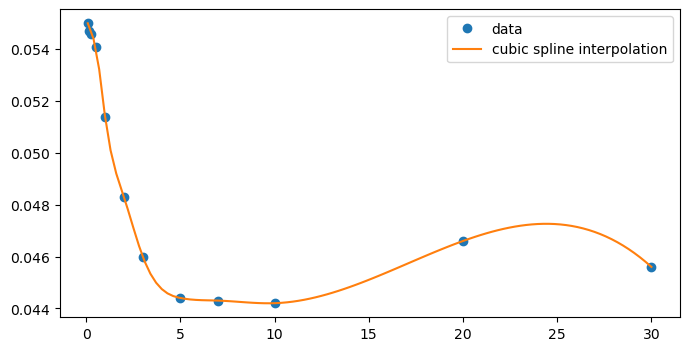

In [4]:
from scipy.interpolate import CubicSpline

cs = CubicSpline(yield_maturities, yeilds)


# Interpolated values at specific points
x_new = np.linspace(1/12, 30, 100)
y_new = cs(x_new)

# Optionally, you can plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(yield_maturities, yeilds, 'o', label='data')
plt.plot(x_new, y_new, label='cubic spline interpolation')
plt.legend()
plt.show()

## Black Scholes Pricer

In [5]:
N = norm.cdf

def bs_call(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan  # Return NaN for invalid inputs
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T) * N(d2)

def bs_put(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0 or S <= 0 or K <= 0:
        return np.nan  # Return NaN for invalid inputs
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r*T) * N(-d2) - S * N(-d1)

## BTC and ETH Option Data DERIVIT API

#### Get Market Option Prices for BTC and ETH

In [6]:
# This is the script we ued for scfraping Deribit option data on btc and eth

df_btc = pd.read_csv("/Users/dnn/Option Pricing Model/data/btc_options.csv")
df_eth = pd.read_csv("/Users/dnn/Option Pricing Model/data/eth_options.csv")
df = df_btc

In [7]:
df["price"]= df["index_price"] * df["mark_price"]
df["mark_iv"]= df["mark_iv"]/100

# Convert maturity to numeric if it's in datetime format
df['maturity'] = pd.to_datetime(df['maturity'])
# Calculate the fraction of the year until maturity
df['year_fraction'] = (df['maturity'] - pd.Timestamp('today')).dt.days / 365
# Calculate the risk free rate for each maturity using the fitted yield curve
df['rf_rate'] = df['year_fraction'].apply(cs)

In [8]:
df['bs_price'] = df.apply(
    lambda x: bs_call(x['index_price'], x['strike'], x['year_fraction'], x['rf_rate'], x['mark_iv']) 
    if x['option_type'] == 'call' else 
    bs_put(x['index_price'], x['strike'], x['year_fraction'], x['rf_rate'], x['mark_iv']),
    axis=1)
df = df.dropna()
df[250:]

,option_type,strike,creation,maturity,mark_price,last_price,mark_iv,index_price,price,year_fraction,rf_rate,bs_price
313,call,56000.0,2024-04-24 08:01:00,2024-07-26 08:00:00,0.2416,0.1820,0.5606,68821.59,16627.296144,0.164384,0.054704,14611.946549
314,put,56000.0,2024-04-24 08:01:00,2024-07-26 08:00:00,0.0135,0.0195,0.5606,68821.59,929.091465,0.164384,0.054704,1289.033032
315,call,57000.0,2024-04-24 08:01:00,2024-07-26 08:00:00,0.2301,0.1620,0.5598,68821.73,15835.880073,0.164384,0.054704,13827.287691
316,put,57000.0,2024-04-24 08:01:00,2024-07-26 08:00:00,0.0157,0.0240,0.5598,68821.73,1080.501161,0.164384,0.054704,1495.281968
317,call,58000.0,2024-04-24 08:01:00,2024-07-26 08:00:00,0.2186,0.1520,0.5562,68821.73,15044.430178,0.164384,0.054704,13044.017481
...,...,...,...,...,...,...,...,...,...,...,...,...
573,call,170000.0,2024-03-27 08:01:00,2025-03-28 08:00:00,0.0590,0.1205,0.7367,68811.08,4059.853720,0.835616,0.052359,3268.993680
574,call,180000.0,2024-03-27 08:01:00,2025-03-28 08:00:00,0.0520,0.0625,0.7456,68811.07,3578.175640,0.835616,0.052359,2935.670118
575,put,180000.0,2024-03-27 08:01:00,2025-03-28 08:00:00,1.3876,2.0170,0.7456,68811.07,95482.240732,0.835616,0.052359,106419.064945
576,call,200000.0,2024-03-27 13:12:00,2025-03-28 08:00:00,0.0425,0.0470,0.7601,68811.06,2924.470050,0.835616,0.052359,2381.571018


In [9]:
# Analyze the range and count of strikes and maturities in descending order
strike_counts = df['strike'].value_counts().sort_values(ascending=False)
print("Strike counts in descending order:")
print(strike_counts.head(10))

Strike counts in descending order:
70000.0    16
60000.0    14
65000.0    14
62000.0    13
80000.0    13
75000.0    13
56000.0    12
50000.0    12
90000.0    12
54000.0    12
Name: strike, dtype: int64


In [10]:
# Define the strike range based on observed data density
'''min_strike = 2500
max_strike = 6000'''

min_strike = 55000
max_strike = 80000

df = df[(df['strike'] >= min_strike) & (df['strike'] <= max_strike) & 
                 (df['year_fraction'] > 0.02) & (df['year_fraction'] < 1)]
df

,option_type,strike,creation,maturity,mark_price,last_price,mark_iv,index_price,price,year_fraction,rf_rate,bs_price
156,put,56000.0,2024-05-09 08:01:00,2024-06-07 08:00:00,0.0008,0.0015,0.5938,68793.39,55.034712,0.030137,0.055404,52.475193
157,call,58000.0,2024-05-09 08:01:00,2024-06-07 08:00:00,0.1806,0.1600,0.5529,68793.39,12424.086234,0.030137,0.055404,10977.549365
158,put,58000.0,2024-05-09 08:01:00,2024-06-07 08:00:00,0.0012,0.0016,0.5529,68793.39,82.552068,0.030137,0.055404,87.396503
159,call,60000.0,2024-05-09 08:01:00,2024-06-07 08:00:00,0.1531,0.1325,0.5214,68793.48,10532.281788,0.030137,0.055404,9052.652352
160,put,60000.0,2024-05-09 08:01:00,2024-06-07 08:00:00,0.0020,0.0017,0.5214,68793.48,137.586960,0.030137,0.055404,159.072840
...,...,...,...,...,...,...,...,...,...,...,...,...
550,put,70000.0,2024-03-27 08:01:00,2025-03-28 08:00:00,0.1865,0.0980,0.6675,68810.70,12833.195550,0.835616,0.052359,15388.725053
551,call,75000.0,2024-05-01 11:08:00,2025-03-28 08:00:00,0.2547,0.1940,0.6782,68811.07,17526.179529,0.835616,0.052359,15662.193507
552,put,75000.0,2024-05-01 11:08:00,2025-03-28 08:00:00,0.2279,0.3475,0.6782,68811.07,15682.042853,0.835616,0.052359,18640.483852
553,call,80000.0,2024-03-27 08:01:00,2025-03-28 08:00:00,0.2318,0.2370,0.6818,68811.26,15950.450068,0.835616,0.052359,14156.476004


## Volatility Surface

In [11]:
volatility_surface = df.pivot_table(
    index='year_fraction',       # Maturity as index
    columns='strike',       # Strike price as columns
    values='mark_iv',  # Volatility as values
    aggfunc=np.mean          # Aggregation function, taking mean if multiple values exist
)

# Fill missing values by interpolation
volatility_surface.interpolate(method='linear', axis=0, inplace=True)  # Interpolate along maturity
volatility_surface.interpolate(method='linear', axis=1, inplace=True)  # Interpolate along strike

# Convert index and columns to numeric if they're not already
volatility_surface.index = pd.to_numeric(volatility_surface.index, errors='coerce')
volatility_surface.columns = pd.to_numeric(volatility_surface.columns, errors='coerce')


volatility_surface

strike,55000.0,56000.0,57000.0,58000.0,59000.0,60000.0,61000.0,62000.0,63000.0,64000.0,65000.0,66000.0,67000.0,68000.0,69000.0,70000.0,71000.0,72000.0,73000.0,74000.0,75000.0,76000.0,77000.0,78000.0,79000.0,80000.0
year_fraction,,,,,,,,,,,,,,,,,,,,,,,,,,
0.030137,NaN,0.5938,0.57335,0.5529,0.537150,0.52140,0.504500,0.4945,0.4893,0.4712,0.4685,0.4594,0.4566,0.4498,0.45570,0.4545,0.454300,0.4555,0.5255,0.52550,0.5255,0.5255,0.56070,0.5959,0.63110,0.6663
0.049315,NaN,0.5495,0.54895,0.5484,0.537925,0.52745,0.520933,0.4927,0.4900,0.4862,0.4862,0.4834,0.4801,0.4801,0.48120,0.4827,0.477000,0.4860,0.4826,0.51820,0.5255,0.5182,0.51820,0.5182,0.51825,0.5183
0.087671,0.5667,0.5588,0.55000,0.5412,0.537350,0.53350,0.537367,0.5235,0.5219,0.5197,0.5180,0.5167,0.5170,0.5167,0.51555,0.5186,0.516475,0.5251,0.5227,0.52430,0.5255,0.5425,0.53905,0.5356,0.55045,0.5653
0.164384,0.5649,0.5606,0.55980,0.5562,0.553700,0.55380,0.553800,0.5538,0.5538,0.5538,0.5538,0.5539,0.5539,0.5539,0.54990,0.5562,0.555950,0.5612,0.5628,0.55945,0.5618,0.5668,0.56710,0.5687,0.57170,0.5717
0.336986,0.6253,0.6253,0.55980,0.6253,0.553700,0.62530,0.553800,0.6253,0.5538,0.5538,0.6253,0.5539,0.5539,0.5539,0.54990,0.6032,0.555950,0.6085,0.5628,0.55945,0.6126,0.5668,0.56710,0.5687,0.57170,0.6188
0.586301,0.6544,0.6544,0.55980,0.6544,0.553700,0.65445,0.553800,0.6545,0.5538,0.5538,0.6545,0.5539,0.5539,0.5539,0.54990,0.6479,0.555950,0.6558,0.5628,0.55945,0.6526,0.5668,0.56710,0.5687,0.57170,0.6576
0.835616,0.6544,0.6544,0.55980,0.6544,0.553700,0.67700,0.553800,0.6545,0.5538,0.5538,0.6545,0.5539,0.5539,0.5539,0.54990,0.6675,0.555950,0.6558,0.5628,0.55945,0.6782,0.5668,0.56710,0.5687,0.57170,0.6818


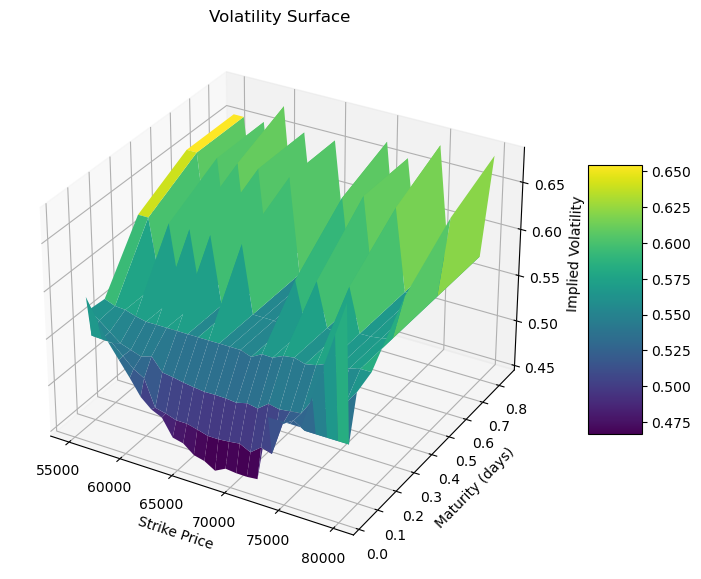

In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

X = volatility_surface.columns.values
Y = volatility_surface.index.values
X, Y = np.meshgrid(X, Y)
Z = volatility_surface.values

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Strike Price')
ax.set_ylabel('Maturity (days)')
ax.set_zlabel('Implied Volatility')
ax.set_title('Volatility Surface')
plt.show()

In [13]:
# Set pandas option to avoid scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df = df[['option_type','index_price','mark_iv','year_fraction','strike','maturity','rf_rate','price']]
df

,option_type,index_price,mark_iv,year_fraction,strike,maturity,rf_rate,price
156,put,68793.39000,0.59380,0.03014,56000.00000,2024-06-07 08:00:00,0.05540,55.03471
157,call,68793.39000,0.55290,0.03014,58000.00000,2024-06-07 08:00:00,0.05540,12424.08623
158,put,68793.39000,0.55290,0.03014,58000.00000,2024-06-07 08:00:00,0.05540,82.55207
159,call,68793.48000,0.52140,0.03014,60000.00000,2024-06-07 08:00:00,0.05540,10532.28179
160,put,68793.48000,0.52140,0.03014,60000.00000,2024-06-07 08:00:00,0.05540,137.58696
...,...,...,...,...,...,...,...,...
550,put,68810.70000,0.66750,0.83562,70000.00000,2025-03-28 08:00:00,0.05236,12833.19555
551,call,68811.07000,0.67820,0.83562,75000.00000,2025-03-28 08:00:00,0.05236,17526.17953
552,put,68811.07000,0.67820,0.83562,75000.00000,2025-03-28 08:00:00,0.05236,15682.04285
553,call,68811.26000,0.68180,0.83562,80000.00000,2025-03-28 08:00:00,0.05236,15950.45007


## Calibration

### Parameters to determine via calibration with market prices

$\Large \Theta = (v0, \kappa, \theta, \sigma, \rho, \lambda)$

Minimize squared error:



$\Large SqErr(\Theta) = \sum^N_{i=1}\sum^M_{j=1}w_{ij}(C_{MP}(X_i,\tau_j) - C_{SV}(S_\tau, X_i,\tau_j,r_j,\Theta))^2 + Penalty(\Theta, \Theta_0)$

- The penalty function may be e. g. the distance to the initial parameter $vectorPenalty(\Theta, \Theta_0) = ||\Theta − \Theta_0||^2$


### Calibration - Optimization Objective function

$\Large \hat{\Theta} = \underset{\Theta \in U_\Theta}{arg \ min} \ SqErr(\Theta)$

Here we assume that the  set of possible combinations of parameters $U_\Theta$ is compact and in the range for which a solution exists.

In [14]:
def setup_helpers(engine, df, calculation_date, calendar, day_count, yield_ts, dividend_ts):
    heston_helpers = []
    for index, row in df.iterrows():
        maturity_date = ql.Date(row['maturity'].day, row['maturity'].month, row['maturity'].year)
        period = ql.Period(maturity_date - calculation_date, ql.Days)
        helper = ql.HestonModelHelper(period, calendar, row['index_price'], row['strike'], 
                                      ql.QuoteHandle(ql.SimpleQuote(row['mark_iv'])), yield_ts, dividend_ts)
        helper.setPricingEngine(engine)
        heston_helpers.append(helper)
    return heston_helpers

In [15]:
def calibration_report(theta, kappa, sigma, rho, v0, helpers):
    # Output calibrated parameters
    print(f"\nCalibrated Parameters - Theta: {theta}, Kappa: {kappa}, Sigma: {sigma}, Rho: {rho}, V0: {v0}\n")

    mse_sum_error = 0.0
    mae_sum_error = 0.0
    sum_market_price = 0.0
    count = 0

    for helper in helpers:
        model_value = helper.modelValue()
        market_value = helper.marketValue()
        mse_error = (model_value - market_value) ** 2
        mae_error = abs(model_value - market_value)
        mse_error_percent = mse_error / market_value ** 2 * 100
        mae_error_percent = mae_error / market_value * 100

        mse_sum_error += mse_error_percent
        mae_sum_error += mae_error_percent
        sum_market_price += market_value
        count += 1

    # Calculate average errors
    mse_avg_error = mse_sum_error / count
    mae_avg_error = mae_sum_error / count
    arpe_avg_error = (mae_sum_error / sum_market_price) * 100  # Convert to percentage

    print("-" * 100)
    print(f"Average Mean Square Error - MSE (%): {mse_avg_error:.3f}")
    print(f"Average Absolute Percentage Error - MAE (%): {mae_avg_error:.3f}")
    print(f"Average Relative Percentage Error - ARPE (%): {arpe_avg_error:.3f}\n")

    return mse_avg_error, mae_avg_error, arpe_avg_error

In [16]:
# Define the functions
def setup_model(spot, rf_rate, calculation_date, day_count, theta, kappa, sigma, rho, v0):
    
    
    # Create term structures
    yield_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, rf_rate, day_count))
    dividend_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 0.0, day_count))
    
    # Create the Heston process with the provided term structures and model parameters
    process = ql.HestonProcess(yield_ts, dividend_ts, ql.QuoteHandle(ql.SimpleQuote(spot)), v0, kappa, theta, sigma, rho)
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    return model, engine, yield_ts, dividend_ts

In [17]:
def quantlib_calibration(init_condition, optimization_algorithm):
    
    # Model parameters
    theta, kappa, sigma, rho, v0 = init_condition

    # Setup the model and engine once using average or representative values
    model, engine, yield_ts, dividend_ts= setup_model(average_spot, average_rf_rate, calculation_date, day_count, theta, kappa, sigma, rho, v0)

    # Setup helpers for all options
    helpers = setup_helpers(engine, df, calculation_date, calendar, day_count, yield_ts, dividend_ts)

    # Calibration
    if optimization_algorithm == 'LevenbergMarquardt':
        optimizer = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
    elif optimization_algorithm == 'Simplex':
        optimizer = ql.Simplex(1.0)
    elif optimization_algorithm == 'BFGS':
        optimizer = ql.BFGS()
    elif optimization_algorithm == 'ConjugateGradient':
        optimizer = ql.ConjugateGradient()
    else:
        print("Choose a optimization algorithm between: LevenbergMarquardt, Simplex, BFGS, and ConjugateGradient")
        return

    model.calibrate(helpers, optimizer, ql.EndCriteria(10000, 1000, 1.0e-8,1.0e-8, 1.0e-8))
    theta, kappa, sigma, rho, v0 = model.params()

    return(theta, kappa, sigma, rho, v0, helpers)
  

## Initial Setup

In [18]:
summary = []
# Initial setup
calculation_date = ql.Date(25, 5, 2024)
ql.Settings.instance().evaluationDate = calculation_date
calendar = ql.NullCalendar()
day_count = ql.Actual365Fixed()

average_spot = df['index_price'].mean()  # Example: use the average or another representative spot price
average_rf_rate = df['rf_rate'].mean()  # Example: use the average or another representative risk-free rate

init_condition = (0.02, 0.2, 0.5, -0.75, 0.01)

## LevenbergMarquardt

Combines the gradient descent and Gauss-Newton methods.

In [19]:
optimization_algorithm = 'LevenbergMarquardt'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.5436529611137285, Kappa: 8.813243323351248, Sigma: 4.763333626603516, Rho: 0.10750112869468462, V0: 0.20366224027408283

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 0.352
Average Absolute Percentage Error - MAE (%): 3.336
Average Relative Percentage Error - ARPE (%): 0.087



As LevenebergMarquart is a local optimizer we can highlight the fact that it depedns a lot on the initialization

In [20]:
init_condition_2 = (0.9,0.5,0.1,0.9,0.01)


theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition_2, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    


Calibrated Parameters - Theta: 1.1309960956201701, Kappa: 0.646570829676652, Sigma: 3.5746186788158175e-10, Rho: 0.011058200050344216, V0: 0.025072072292957062

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 56.948
Average Absolute Percentage Error - MAE (%): 72.284
Average Relative Percentage Error - ARPE (%): 1.881



# Simplex
A derivative-free method, useful for noisy functions.

In [21]:
optimization_algorithm = 'Simplex'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.348730211643289, Kappa: 76.13795990582466, Sigma: 0.5685418542154937, Rho: -0.9999997545152084, V0: 0.03626214642926007

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 1.774
Average Absolute Percentage Error - MAE (%): 10.231
Average Relative Percentage Error - ARPE (%): 0.266



## ConjugateGradient
Uses gradients to find the minimum of a function.

In [22]:
optimization_algorithm = 'ConjugateGradient'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.19444488027548798, Kappa: 4.553523818695839e-08, Sigma: 0.19517493552147688, Rho: -0.6436505544345194, V0: 0.2835932193326095

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 3.176
Average Absolute Percentage Error - MAE (%): 14.494
Average Relative Percentage Error - ARPE (%): 0.377



## BFGS
An iterative method that uses both gradient and approximation to the Hessian;

In [23]:
optimization_algorithm = 'BFGS'

theta, kappa, sigma, rho, v0, helpers = quantlib_calibration(init_condition, optimization_algorithm)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["QuantLib " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])


Calibrated Parameters - Theta: 0.2024132415397664, Kappa: 9.629304174705936e-09, Sigma: 0.17568500718457336, Rho: -0.6186772769014259, V0: 0.28342711055606545

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 3.169
Average Absolute Percentage Error - MAE (%): 14.548
Average Relative Percentage Error - ARPE (%): 0.379



# Scipy

Using Scipy, we can implement a personalized cost_function to minimize so we will also try to add penalization to have a more robust model

#### Using Scipy Levenberg-Marquardt Solver

In [24]:
def safe_calibration_error(helper):
    try:
        return helper.calibrationError()
    except RuntimeError:
        return np.inf  # Return a large number to signify error without printing

def cost_function_generator(model, helpers, penalty_factor, optimization_algo):
    def cost_function(params):
        try:
            params_ = ql.Array(list(params))
            model.setParams(params_)

            # Collect errors depending on the optimization algorithm
            errors = []
            for helper in helpers:
                error = safe_calibration_error(helper)
                if optimization_algo == 'L-BFGS-B' or optimization_algo == 'differential_evolution' :
                    # Cap the error to avoid overflow issues and use squared errors for scalar optimization
                    error = min(error, 1e6) ** 2
                errors.append(error)

            # Convert errors list to numpy array for efficient computation
            errors = np.array(errors)
            if optimization_algo == 'L-BFGS-B' or optimization_algo == 'differential_evolution':
                # Sum up errors for scalar optimization
                total_error = np.sum(errors)
            else:
                # Return the array of errors for methods expecting multiple residuals
                total_error = errors

            # Apply penalties if applicable
            if penalty_factor is not None:
                penalty = penalty_factor * np.sum(np.square(np.array(params)))
                total_error += penalty

            return total_error
        except Exception as e:
            # Handle any exception by returning a large error
            print("An error occurred: ", e)
            if optimization_algo == 'L-BFGS-B' or optimization_algo == 'differential_evolution':
                return np.inf
            else:
                return np.full(len(params), np.inf)

    return cost_function

In [28]:
def scipy_calibration(init_condition, optimization_algorithm, penalization):
    
    # Model parameters
    theta, kappa, sigma, rho, v0 = init_condition

    # Setup the model and engine once using average or representative values
    model, engine, yield_ts, dividend_ts = setup_model(average_spot, average_rf_rate, calculation_date, day_count, theta, kappa, sigma, rho, v0)

    # Setup helpers for all options
    helpers = setup_helpers(engine, df, calculation_date, calendar, day_count, yield_ts, dividend_ts)
    
    
    if optimization_algorithm == 'lm':
        cost_function = cost_function_generator(model, helpers, penalization, optimization_algorithm)
        result = root(cost_function, init_condition, method=optimization_algorithm)
    elif optimization_algorithm == 'L-BFGS-B':
        cost_function = cost_function_generator(model, helpers, penalization, optimization_algorithm)
        bounds = [(0.001, None), (0.001, None), (0.001, None), (-0.999, 0.999), (0.001, None)] 
        result = minimize(cost_function, init_condition, method=optimization_algorithm, bounds=bounds)
    elif optimization_algorithm == 'differential_evolution':
        cost_function = cost_function_generator(model, helpers, penalization, optimization_algorithm)
        bounds = [(0,1),(0.01,15), (0.01,1.), (-1,1), (0,1.0) ]
        result = differential_evolution(cost_function, bounds, maxiter=10000)
    else:
        print("Choose a optimization algorithm between: LevenbergMarquardt: 'lm', L-BFGS-B")
        return
        

    if result.success:
        theta, kappa, sigma, rho, v0 = result.x
        print("Calibration successful:")
    else:
        print("Calibration failed:", result.message)
    return(theta, kappa, sigma, rho, v0, helpers)
  

In [29]:
penalization = 0.001
init_condition = (0.02, 0.2, 0.5, -0.75, 0.01)

## LevenbergMarquardt with Scipy


In [30]:
optimization_algorithm = 'lm'
theta, kappa, sigma, rho, v0, helpers = scipy_calibration(init_condition, optimization_algorithm, penalization)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["Scipy LevenbergMarquardt", mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])

Calibration successful:

Calibrated Parameters - Theta: 1.0072095404940586, Kappa: 2.283421514279028, Sigma: -2.947793445436052, Rho: -0.07374728620530192, V0: 0.22523352387327403

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 0.501
Average Absolute Percentage Error - MAE (%): 4.957
Average Relative Percentage Error - ARPE (%): 0.129



## L-BFGS with Scipy

In [31]:
optimization_algorithm = 'L-BFGS-B'
theta, kappa, sigma, rho, v0, helpers = scipy_calibration(init_condition, optimization_algorithm, penalization)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["Scipy " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])

Calibration successful:

Calibrated Parameters - Theta: 0.5899774499804123, Kappa: 6.886916912287298, Sigma: 4.4265543761130655, Rho: 0.1032166596827018, V0: 0.20973434529358737

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 0.359
Average Absolute Percentage Error - MAE (%): 3.426
Average Relative Percentage Error - ARPE (%): 0.089



## Global Optimization - Differential Evolution

In [32]:
from scipy.optimize import differential_evolution

In [33]:
optimization_algorithm = 'differential_evolution'
theta, kappa, sigma, rho, v0, helpers = scipy_calibration(init_condition, optimization_algorithm, penalization)
mse_avg_error, mae_avg_error, arpe_avg_error = calibration_report(theta, kappa, sigma, rho, v0, helpers)    
summary.append(["Scipy " + optimization_algorithm, mse_avg_error, mae_avg_error, 
                arpe_avg_error, theta, kappa, sigma, rho, v0])

Calibration successful:

Calibrated Parameters - Theta: 0.6699969038784985, Kappa: 2.5771174307209344, Sigma: 1.0, Rho: -0.1312940590425449, V0: 0.23532903814838924

----------------------------------------------------------------------------------------------------
Average Mean Square Error - MSE (%): 1.038
Average Absolute Percentage Error - MAE (%): 6.382
Average Relative Percentage Error - ARPE (%): 0.166



### Summary

In [34]:
result_df = pd.DataFrame(summary,
                      columns=["Method", "MSE (%)", "MAE (%)", "ARPE (%)","Theta (Long Run Variance)", "Kappa (Mean Reversion Rate)", "Sigma (Volatility of variance)", "Rho (Correlation)", "V0 (Initial Variance)"],
                      index=['']*len(summary))
result_df

,Method,MSE (%),MAE (%),ARPE (%),Theta (Long Run Variance),Kappa (Mean Reversion Rate),Sigma (Volatility of variance),Rho (Correlation),V0 (Initial Variance)
,QuantLib LevenbergMarquardt,0.35175,3.33580,0.08683,0.54365,8.81324,4.76333,0.10750,0.20366
,QuantLib Simplex,1.77374,10.23143,0.26631,0.34873,76.13796,0.56854,-1.00000,0.03626
,QuantLib ConjugateGradient,3.17584,14.49389,0.37726,0.19444,0.00000,0.19517,-0.64365,0.28359
,QuantLib BFGS,3.16859,14.54756,0.37866,0.20241,0.00000,0.17569,-0.61868,0.28343
,Scipy LevenbergMarquardt,0.50088,4.95693,0.12902,1.00721,2.28342,-2.94779,-0.07375,0.22523
,Scipy L-BFGS-B,0.35906,3.42624,0.08918,0.58998,6.88692,4.42655,0.10322,0.20973
,Scipy differential_evolution,1.03830,6.38184,0.16611,0.67000,2.57712,1.00000,-0.13129,0.23533
